In [0]:
# Imports

import glob
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape
from keras.optimizers import Adam
from keras.layers.wrappers import Bidirectional
from keras.applications.mobilenet import MobileNet
from keras.preprocessing import image
import nltk

Using TensorFlow backend.


In [0]:
# Sanity check : folders in the file system
!ls

# file  ids for download
# after uploading the dataset to Google Drive, obtain requisite file ids
dataset_id = '1q_d8VQPFY6wJIhoOf8MtZ16GDvjTUH-G'
text_file_id = '1QUmbXoP8ONtQOGYOeNPY9zXfpFj0Cn02'

sample_data


## Dataset Preparation

In [0]:
'''Code Snippet for downloading from Google Drive'''

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
# file_id = 'REPLACE_WITH_YOUR_FILE_ID'
text_file = drive.CreateFile({'id': text_file_id})
print('Downloaded content')
dataset = drive.CreateFile({'id': dataset_id})
print('Downloaded content')

Downloaded content
Downloaded content


In [0]:
images_ = dataset.GetContentFile('Flickr8k_Dataset.zip')
labels_ = text_file.GetContentFile('Flickr8k_text.zip')

In [0]:
!ls

adc.json  Flickr8k_Dataset.zip	Flickr8k_text.zip  sample_data


In [0]:
!unzip Flickr8k_Dataset.zip
!unzip Flickr8k_text.zip

Archive:  Flickr8k_Dataset.zip
   creating: Flicker8k_Dataset/
  inflating: Flicker8k_Dataset/1000268201_693b08cb0e.jpg  
   creating: __MACOSX/
   creating: __MACOSX/Flicker8k_Dataset/
  inflating: __MACOSX/Flicker8k_Dataset/._1000268201_693b08cb0e.jpg  
  inflating: Flicker8k_Dataset/1001773457_577c3a7d70.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._1001773457_577c3a7d70.jpg  
  inflating: Flicker8k_Dataset/1002674143_1b742ab4b8.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._1002674143_1b742ab4b8.jpg  
  inflating: Flicker8k_Dataset/1003163366_44323f5815.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._1003163366_44323f5815.jpg  
  inflating: Flicker8k_Dataset/1007129816_e794419615.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._1007129816_e794419615.jpg  
  inflating: Flicker8k_Dataset/1007320043_627395c3d8.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._1007320043_627395c3d8.jpg  
  inflating: Flicker8k_Dataset/1009434119_febe49276a.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/

In [0]:
!ls;

adc.json		    Flickr_8k.devImages.txt   Flickr_8k.trainImages.txt
CrowdFlowerAnnotations.txt  Flickr8k.lemma.token.txt  __MACOSX
ExpertAnnotations.txt	    Flickr_8k.testImages.txt  readme.txt
Flicker8k_Dataset	    Flickr8k_text.zip	      sample_data
Flickr8k_Dataset.zip	    Flickr8k.token.txt


In [0]:
token = 'Flickr8k.token.txt'

In [0]:
captions = open(token, 'r').read().strip().split('\n')

In [0]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [0]:
d['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [0]:
images = 'Flicker8k_Dataset/'  # images folder

In [0]:

img = glob.glob(images+'*.jpg')
type(img)

list

In [0]:
len(img)

8091

In [0]:
train_images_file = 'Flickr_8k.trainImages.txt'
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
print(type(train_images))
len(train_images)

<class 'set'>


6000

In [0]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp
  
train_img = split_data(train_images)
len(train_img)

6000

In [0]:
val_images_file = 'Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

In [0]:
val_img = split_data(val_images)
len(val_img)

1000

In [0]:
test_images_file = 'Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))
test_img = split_data(test_images)
len(test_img)

1000

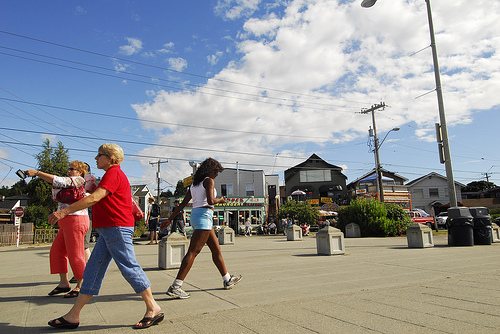

In [0]:
Image.open(train_img[6])

## Model Construction


In [0]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x
  
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

In [0]:
# importing MobileNet

mobilenet = MobileNet(weights='imagenet',include_top = True, input_shape = (224,224,3))
from keras.models import Model

new_input = mobilenet.input
hidden_layer = mobilenet.get_layer('conv_preds').output
mobilenet = Model(new_input, hidden_layer)

#mobilenet.summary()

17227776/17225924 [==============================] - 2s 0us/step


In [0]:
from keras.models import Model, Sequential
x = Flatten()(mobilenet.output)

model_new = Model(input = mobilenet.input, output = x)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fl...)`
  after removing the cwd from sys.path.


In [0]:
tryi = model_new.predict(preprocess(train_img[0]))

In [0]:
tryi.shape

(1, 1000)

In [0]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, 1000)
    return temp_enc
t = encode(train_img[0])
t.shape

(1000,)

In [0]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)

100%|██████████| 6000/6000 [01:53<00:00, 52.97it/s]


In [0]:
with open("encoded_images_mobilenet.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) 

In [0]:
encoding_train = pickle.load(open('encoded_images_mobilenet.p', 'rb'))

In [0]:
encoding_train['3556792157_d09d42bef7.jpg'].shape

(1000,)

In [0]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

100%|██████████| 1000/1000 [00:17<00:00, 57.72it/s]


In [0]:
with open("encoded_images_test_mobilenet.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle) 

encoding_test = pickle.load(open('encoded_images_test_mobilenet.p', 'rb'))

In [0]:
encoding_test[test_img[0][len(images):]].shape # images is the name of the folder Flickr8k_Dataset

(1000,)

In [0]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [0]:
len(train_d)

6000

In [0]:
train_d[images+'3556792157_d09d42bef7.jpg']

['A bunch of children sitting in chairs and standing on wooden floors .',
 'A group of children sit , stand , and kneel along a wall .',
 'A group of children sitting on folding chairs and playing .',
 'a young group of children sitting in a row against the wall .',
 'The kids talking while sitting on a row of chairs along the wall .']

In [0]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]
        
len(val_d)

1000

In [0]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]
        
len(test_d)

1000

In [0]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [0]:
words = [i.split() for i in caps]

In [0]:
unique = []
for i in words:
    unique.extend(i)

In [0]:
unique = list(set(unique))

In [0]:
with open("unique.p", "wb") as pickle_d:
    pickle.dump(unique, pickle_d) 

In [0]:
unique = pickle.load(open('unique.p', 'rb'))

In [0]:
len(unique)

8256

In [0]:
word2idx = {val:index for index, val in enumerate(unique)}
word2idx['<start>']

7693

In [0]:
idx2word = {index:val for index, val in enumerate(unique)}

In [0]:
idx2word[3968]

'raceway'

In [0]:
print(json.dumps(word2idx))

{"sparse": 0, "necklaces": 1, "married": 2, "dolly": 3, "foyer": 4, "interested": 5, "Bright": 6, "land": 7, "manequins": 8, "minding": 9, "Thank": 10, "here": 11, "butterfly-catcher": 12, "sweatshirts": 13, "index": 14, "mine": 15, "production": 16, "moniter": 17, "small": 18, "peeping": 19, "insect": 20, "protected": 21, "reflective": 22, "blog": 23, "offering": 24, "goes": 25, "Zara": 26, "containig": 27, "clears": 28, "relatively": 29, "cornfield": 30, "electricity": 31, "amidst": 32, "soda": 33, "table": 34, "objective": 35, "<end>": 36, "cowboy": 37, "paintings": 38, "ability": 39, "multicolored": 40, "waterboard": 41, "fake": 42, "bar-type": 43, "Hawaiian": 44, "mingling": 45, "deeper": 46, "shoe": 47, "motion": 48, "paralell": 49, "uggs": 50, "though": 51, "We": 52, "twirls": 53, "led": 54, "shook": 55, "shed": 56, "doberman": 57, "chased": 58, "poses": 59, "trampoline": 60, "Flames": 61, "punctured": 62, "Springer": 63, "headphones": 64, "flattened": 65, "continue": 66, "name"

In [0]:
print(json.dumps(idx2word))

{"0": "sparse", "1": "necklaces", "2": "married", "3": "dolly", "4": "foyer", "5": "interested", "6": "Bright", "7": "land", "8": "manequins", "9": "minding", "10": "Thank", "11": "here", "12": "butterfly-catcher", "13": "sweatshirts", "14": "index", "15": "mine", "16": "production", "17": "moniter", "18": "small", "19": "peeping", "20": "insect", "21": "protected", "22": "reflective", "23": "blog", "24": "offering", "25": "goes", "26": "Zara", "27": "containig", "28": "clears", "29": "relatively", "30": "cornfield", "31": "electricity", "32": "amidst", "33": "soda", "34": "table", "35": "objective", "36": "<end>", "37": "cowboy", "38": "paintings", "39": "ability", "40": "multicolored", "41": "waterboard", "42": "fake", "43": "bar-type", "44": "Hawaiian", "45": "mingling", "46": "deeper", "47": "shoe", "48": "motion", "49": "paralell", "50": "uggs", "51": "though", "52": "We", "53": "twirls", "54": "led", "55": "shook", "56": "shed", "57": "doberman", "58": "chased", "59": "poses", "6

In [0]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [0]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [0]:
model_new.summary() # keras model 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [0]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
len(df)

30000

In [0]:
c = [i for i in df['captions']]
len(c)

30000

In [0]:
imgs = [i for i in df['image_id']]

In [0]:
a = c[-1]
a, imgs[-1]

('<start> Two surfers walk along a rock wall to reach the waves . <end>',
 '222369445_5b6af347dd.jpg')

In [0]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [0]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

In [0]:
embedding_size = 64
vocab_size = len(unique)

In [0]:
from keras.models import Model
from keras.layers import Input, Dense

In [0]:
# Constructing the image Model

image_inp = Input(shape=(1000,))
image_model = Dense(embedding_size,input_shape=(1000,),activation='relu')(image_inp)
image_model = RepeatVector(max_len)(image_model)

# image_model = Model(input=model_new.input,output = image_top(model_new.output))

In [0]:
# Constructing Caption Model

caption_inp = Input(shape=(max_len,))
caption_model = Embedding(vocab_size, embedding_size, input_length=max_len)(caption_inp)
caption_model = LSTM(128,return_sequences=True)(caption_model)
caption_model = TimeDistributed(Dense(64))(caption_model)

In [0]:
# check : https://stackoverflow.com/questions/45930844/how-to-merge-keras-sequential-models-with-same-input
# and : https://stackoverflow.com/questions/43196636/how-to-concatenate-two-layers-in-keras
# also: https://keras.io/layers/merge/#concatenate
from keras.layers import concatenate, Concatenate

In [0]:
# Merging the two

merge_model = Concatenate(axis=1)([image_model, caption_model])
merge_model = Bidirectional(LSTM(128, return_sequences=False))(merge_model)
merge_model = Dense(vocab_size)(merge_model)
merge_model = Activation('softmax')(merge_model)

In [0]:
final_model = Model(inputs=[image_inp,caption_inp],outputs=merge_model)

In [0]:
from keras.optimizers import Adam
final_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [0]:
final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 64)       528384      input_3[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           64064       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LS

## Training

In [0]:
final_model.fit_generator(data_generator(batch_size=256), samples_per_epoch=512, nb_epoch=30, 
                          verbose=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=1, steps_per_epoch=512, epochs=30)`
  


Epoch 1/30
512/512 [==============================] - 282s 550ms/step - loss: 5.4995 - acc: 0.0851
Epoch 2/30
512/512 [==============================] - 274s 535ms/step - loss: 5.0320 - acc: 0.1235
Epoch 3/30
512/512 [==============================] - 276s 538ms/step - loss: 4.9724 - acc: 0.1253
Epoch 4/30
512/512 [==============================] - 275s 538ms/step - loss: 4.5723 - acc: 0.2150
Epoch 5/30
512/512 [==============================] - 276s 540ms/step - loss: 4.3445 - acc: 0.2521
Epoch 6/30
512/512 [==============================] - 275s 537ms/step - loss: 4.0326 - acc: 0.2925
Epoch 7/30
512/512 [==============================] - 274s 536ms/step - loss: 3.8198 - acc: 0.3119
Epoch 8/30
512/512 [==============================] - 275s 537ms/step - loss: 3.7244 - acc: 0.3189
Epoch 9/30
512/512 [==============================] - 276s 539ms/step - loss: 3.6228 - acc: 0.3302
Epoch 10/30
512/512 [==============================] - 276s 538ms/step - loss: 3.5114 - acc: 0.3405
Epoch 11/

In [0]:
final_model.fit_generator(data_generator(batch_size=256), samples_per_epoch=512, nb_epoch=120, 
                          verbose=1)

512/512 [==============================] - 292s 570ms/step - loss: 2.6158 - acc: 0.4232
Epoch 3/120
512/512 [==============================] - 284s 555ms/step - loss: 2.6014 - acc: 0.4257
Epoch 4/120
512/512 [==============================] - 280s 547ms/step - loss: 2.5567 - acc: 0.4303
Epoch 5/120
512/512 [==============================] - 279s 545ms/step - loss: 2.5537 - acc: 0.4298
Epoch 6/120
512/512 [==============================] - 279s 544ms/step - loss: 2.5235 - acc: 0.4347
Epoch 7/120
512/512 [==============================] - 278s 544ms/step - loss: 2.4967 - acc: 0.4375
Epoch 8/120
512/512 [==============================] - 280s 546ms/step - loss: 2.4919 - acc: 0.4372
Epoch 9/120
512/512 [==============================] - 281s 548ms/step - loss: 2.4593 - acc: 0.4417
Epoch 10/120
512/512 [==============================] - 282s 550ms/step - loss: 2.4475 - acc: 0.4437
Epoch 11/120
512/512 [==============================] - 284s 556ms/step - loss: 2.4387 - acc: 0.4439
Epoch 12/1

## Saving and Testing

In [0]:
final_model.save('mb.h5')
model_new.save('mn.h5')

In [0]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [0]:
try_image = test_img[11]
Image.open(try_image)

In [0]:

print ('caption:', predict_captions(try_image)) 


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

uploaded = drive.CreateFile({'title': 'mb.h5'})
uploaded.SetContentFile('mb.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1iOTpw80DX_Dz9vLK4uq4anWTuJrstjH6


In [0]:
from google.colab import files
files.download('mb.h5') 
# files.download('mn.h5')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 35750, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [0]:
!pip install tensorflowjs

    100% |████████████████████████████████| 61kB 6.5MB/s 
    100% |████████████████████████████████| 307kB 12.6MB/s 
    100% |████████████████████████████████| 13.9MB 3.3MB/s 
keras 2.2.2 has requirement keras-applications==1.0.4, but you'll have keras-applications 1.0.6 which is incompatible.
keras 2.2.2 has requirement keras-preprocessing==1.0.2, but you'll have keras-preprocessing 1.0.5 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
cufflinks 0.14.6 has requirement plotly>=3.0.0, but you'll have plotly 1.12.12 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6
  Found existing installation: tensorflow-hub 0.2.0
    Uninstalling tensorflow-hub-0.2.0:
      Successfully uninstalled tensorflow-hub-0.2.0
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.

In [0]:
!tensorflowjs_converter --input_format keras mb.h5 ./


Using TensorFlow backend.


In [0]:
!ls

adc.json			 Flickr_8k.testImages.txt	__MACOSX
CrowdFlowerAnnotations.txt	 Flickr8k_text.zip		mb.h5
encoded_images_mobilenet.p	 Flickr8k.token.txt		mn.h5
encoded_images_test_mobilenet.p  Flickr_8k.trainImages.txt	model.json
ExpertAnnotations.txt		 flickr8k_training_dataset.txt	readme.txt
Flicker8k_Dataset		 group1-shard1of4		sample_data
Flickr8k_Dataset.zip		 group1-shard2of4		unique.p
Flickr_8k.devImages.txt		 group1-shard3of4
Flickr8k.lemma.token.txt	 group1-shard4of4


In [0]:
files.download('group1-shard1of4')

In [0]:
files.download('group1-shard2of4')
files.download('group1-shard3of4')
files.download('group1-shard4of4')
# files.download('group1-shard5of9')
# files.download('group1-shard6of9')
# files.download('group1-shard7of9')
# files.download('group1-shard8of9')
# files.download('group1-shard9of9')
files.download('model.json')
